In [1]:
# W. Garrett Levine #
# Yale University   #

# Estimating the Range of Host Masses  #
# for the Peas-in-a-Pod Phenomenon     #

# 10_demographics_figure.ipynb #

# This notebook generates Figures 2-3. #

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import pearsonr
from scipy.stats import linregress

from import_data import *


In [2]:
plt.rcParams['font.family'] = 'serif'

earthmass = 5.972E24 # kg
solarmass = 1.989E30 # kg

earthradius = 6.37E8 # cm
solarradius = 6.95E10 # cm

In [3]:
# import the exoplanet catalog from from Berger et al. (2020)
berger = import_berger2020a()
# get the full name of the KOI
berger["KOI_full"] = get_full_KOI_berger(berger["KOI"])

# import some data from the exoplanet archive for bureaucratic purposes
archive = import_exoplanet_archive_KOIs()
df2 = berger.merge(archive, left_on = "KOI_full", right_on = "kepoi_name")

# get a list of the unique hosts
unique = len(df2["KIC"].unique())
print(f"Planets in original catalog: {unique} systems, {len(df2)} planets")

Planets in original catalog: 2956 systems, 3898 planets


In [4]:
# reset the index before we loop through the dataframe
df2 = df2.reset_index(drop=True)

In [5]:
# add a multiplicity column
# for the "original" system multiplicity
# before we do any filtering

orig_mults = []

# loop through all of the entries
for i in range(len(df2["KIC"])):
    row = df2.iloc[i]
    host = row["KIC"]
    host_df = df2[df2["KIC"] == host]
    # get the multiplicity
    multiplicity = len(host_df)
    orig_mults.append(multiplicity)
    
df2["OrigMult"] = np.array(orig_mults)

In [6]:
df2.columns

Index(['KIC', 'KOI', 'PD', 'Radius', 'E_Radius1', 'E_Radius2', 'a', 'E_a',
       'e_a', 'Flux', 'E_flux', 'e_Flux', 'ZAMSFlux', 'Flag', 'KOI_full',
       'kepid', 'kepoi_name', 'kepler_name', 'koi_period', 'koi_srad',
       'koi_srad_err1', 'koi_srad_err2', 'OrigMult'],
      dtype='object')

In [7]:
# cut the planets larger than 16 earth radii
unique = len(df2["KIC"].unique())
print(f"Planets before radius filter: {unique} systems, {len(df2)} planets")

df2 = df2[df2["Radius"] < 16]

unique = len(df2["KIC"].unique())
print(f"Planets after radius filter: {unique} systems, {len(df2)} planets")
print()

# cut the planets with periods longer than 300 days
unique = len(df2["KIC"].unique())
print(f"Planets before period filter: {unique} systems, {len(df2)} planets")

df2 = df2[df2["koi_period"] < 300]

unique = len(df2["KIC"].unique())
print(f"Planets after period filter: {unique} systems, {len(df2)} planets")

Planets before radius filter: 2956 systems, 3898 planets
Planets after radius filter: 2838 systems, 3771 planets

Planets before period filter: 2838 systems, 3771 planets
Planets after period filter: 2651 systems, 3569 planets


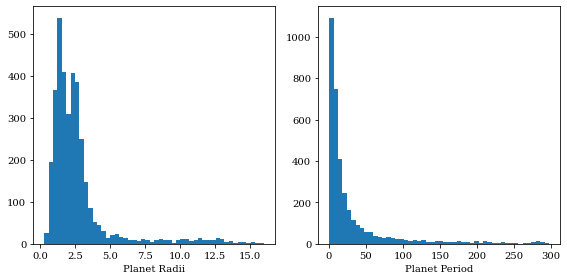

In [8]:
# visually inspect the data to ensure
# that this step worked
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(8)
ax1.hist(df2["Radius"], bins = 50)
ax2.hist(df2["koi_period"], bins = 50)

ax1.set_xlabel("Planet Radii")
ax2.set_xlabel("Planet Period")

fig.tight_layout()

In [9]:
# cut the planets with radius uncertainties
# larger than 50%
unique = len(df2["KIC"].unique())
print(f"Planets before radius uncertainty filter: {unique} systems, {len(df2)} planets")
df2 = df2[(df2["E_Radius1"] + df2["E_Radius2"]) / 2.0 / df2["Radius"] < 0.5]
unique = len(df2["KIC"].unique())
print(f"Planets after radius uncertainty filter: {unique} systems, {len(df2)} planets")

Planets before radius uncertainty filter: 2651 systems, 3569 planets
Planets after radius uncertainty filter: 2623 systems, 3527 planets


In [10]:
### PREPARE DATAFRAME FROM STELLAR CATALOG BY
### BERGER ET AL. (2020b)

# import each star as a single string
berger_stars = np.genfromtxt("data/berger_2020stars.txt", skip_header=45,\
    delimiter = [500], dtype = "str")

# get the required stellar parameters
# and the KIC for matching purposes
KIC_bergerstars = []
Mstar_bergerstars = []
Rstar_bergerstars = []

# loop through the dataframe of stars
# from the Berger et al. (2020) catalog
for i in range(len(berger_stars)):
    entry = berger_stars[i]
    star_kic = int(entry[0:8])
    star_mass = float(entry[9:14])
    star_radius = float(entry[91:98])
    KIC_bergerstars.append(star_kic)
    Mstar_bergerstars.append(star_mass)
    Rstar_bergerstars.append(star_radius)

df_berger_stars = pd.DataFrame([KIC_bergerstars, Mstar_bergerstars, Rstar_bergerstars]).T
df_berger_stars.columns = ["KIC", "Mstar", "Rstar"]

In [11]:
bergerstar_mass = []
bergerstar_rad = []
# loop through the dataframe of all planets
for i in range(len(df2)):
    # in the berger planets dataframe, grab the KIC
    row = df2.iloc[i]
    KIC = row["KIC"]
    # get the corresponding row in df_berger_stars
    bergerstar_row = df_berger_stars[df_berger_stars["KIC"] == KIC]
    # see if berger observed this star
    if len(bergerstar_row) == 1:
        # assuming that only one star in the Berger et al. (2020) 
        # stellar catalog has this KIC
        bergerstar_mass.append(float(bergerstar_row["Mstar"]))
        bergerstar_rad.append(float(bergerstar_row["Rstar"]))
    else:
        # if the star appears in the exoplanet catalog but not
        # the stellar catalog, then flag the issue
        print("could not find KIC :", KIC)

# add these columns to df2, the dataframe with the planetary data
df2["bergerstarmass"] = np.array(bergerstar_mass)
df2["bergerstarradius"] = np.array(bergerstar_rad)

In [12]:
# reprint the number of planets and unique hosts
unique = len(df2["KIC"].unique())
print(f"Planets after period filter: {unique} systems, {len(df2)} planets")

Planets after period filter: 2623 systems, 3527 planets


In [13]:
df2[["KIC", "kepid"]].head()

,KIC,kepid
0,11446443,11446443
2,10748390,10748390
3,3861595,3861595
4,11853905,11853905
5,6922244,6922244


In [14]:
# reset the index before we loop through the dataframe
df2 = df2.reset_index(drop=True)

In [15]:
# remove any systems which only have one
# remaining planet (no longer multi-planet
# or never were multi-planet)
unique = len(df2["KIC"].unique())
print(f"Planets before multiplanet filter: {unique} systems, {len(df2)} planets")

mults = []

# loop through all of the entries
for i in range(len(df2["KIC"])):
    row = df2.iloc[i]
    host = row["KIC"]
    host_df = df2[df2["KIC"] == host]
    # get the multiplicity
    multiplicity = len(host_df)
    mults.append(multiplicity)
    
df2["Mult"] = np.array(mults)
df2 = df2[df2["Mult"] >= 2]

unique = len(df2["KIC"].unique())
print(f"Planets before multiplanet filter: {unique} systems, {len(df2)} planets")

Planets before multiplanet filter: 2623 systems, 3527 planets
Planets before multiplanet filter: 611 systems, 1515 planets


In [16]:
# remove any systems where any of the planets
# planets has been removed by the previous filters

# this criterion is somewhat harsh, but it's fine
# for illustrative purposes
unique = len(df2["KIC"].unique())
print(f"Planets before requiring that all planets survived filtering: {unique} systems, {len(df2)} planets")

df2 = df2[df2["Mult"] == df2["OrigMult"]]

unique = len(df2["KIC"].unique())
print(f"Planets after requiring that all planets survived filtering: {unique} systems, {len(df2)} planets")

Planets before requiring that all planets survived filtering: 611 systems, 1515 planets
Planets after requiring that all planets survived filtering: 595 systems, 1471 planets


In [17]:
# preview the final dataframe for the planets
df2.head()

,KIC,KOI,PD,Radius,E_Radius1,E_Radius2,a,E_a,e_a,Flux,...,kepoi_name,kepler_name,koi_period,koi_srad,koi_srad_err1,koi_srad_err2,OrigMult,bergerstarmass,bergerstarradius,Mult
9,6521045,41.01,CONFIRMED,2.34,0.27,0.09,0.1120,0.0026,0.0029,192.74,...,K00041.01,Kepler-100 c,12.815904,1.474,0.094,-0.079,3,1.140,1.526,3
10,6521045,41.02,CONFIRMED,1.35,0.03,0.11,0.0740,0.0017,0.0019,441.16,...,K00041.02,Kepler-100 b,6.887071,1.474,0.094,-0.079,3,1.140,1.526,3
11,6521045,41.03,CONFIRMED,1.60,0.33,0.09,0.2202,0.0050,0.0056,49.86,...,K00041.03,Kepler-100 d,35.333193,1.474,0.094,-0.079,3,1.140,1.526,3
13,10905239,46.01,CONFIRMED,6.03,0.17,0.16,0.0468,0.0007,0.0006,1102.03,...,K00046.01,Kepler-101 b,3.487689,1.593,0.235,-0.382,2,1.122,1.703,2
14,10905239,46.02,CONFIRMED,1.26,0.06,0.11,0.0674,0.0010,0.0009,531.10,...,K00046.02,Kepler-101 c,6.029772,1.593,0.235,-0.382,2,1.122,1.703,2


In [18]:
# read-in the dataframe on the moons
moons = pd.read_csv("data/moons.csv")
moons = moons.drop([4, 5]) # DROP THE SMALL URANIAN MOONS (MIRANDA, PUCK)

# do some unit conversions
moons["Mass_pl"] = moons["Mass_pl"] / earthmass
moons["Mass_host"] = moons["Mass_host"] / solarmass
moons["Density"] = moons["Mass_pl"] * earthmass* 1000\
    / (4*np.pi/3 * (moons["Radius_pl"] * 1.0E5)**3) #g/cm^3

moons = moons.reset_index()
moons = moons.drop("index", axis = 1)

# add dataframes for Jovian, Saturnian, and Uranian moons
jupiter = moons[moons["Host"] == "Jupiter"]
saturn = moons[moons["Host"] == "Saturn"]
uranus = moons[moons["Host"] == "Uranus"]

In [19]:
# read-in the .csv file for TRAPPIST-1
trappist = pd.read_csv("data/trappist.csv")
trappist["Density"] = trappist["Mass_pl"] * earthmass* 1000\
    / (4*np.pi/3 * (trappist["Radius_pl"] * earthradius)**3) #g/cm^3

In [20]:
jupiter.head()

,Moon,Host,Mass_pl,Mass_host,Radius_pl,Radius_host,Period,Semimajor,Density
0,Io,Jupiter,0.014936,0.000905,1821.0,69950,1.769,421800.0,3.526520
1,Europa,Jupiter,0.008038,0.000905,1560.0,69950,3.551,671100.0,3.018414
2,Ganymede,Jupiter,0.024782,0.000905,2631.0,69950,7.155,1070000.0,1.940039
3,Callisto,Jupiter,0.018084,0.000905,2410.0,69950,16.690,1880000.0,1.841976


In [21]:
uranus.head()

,Moon,Host,Mass_pl,Mass_host,Radius_pl,Radius_host,Period,Semimajor,Density
4,Ariel,Uranus,0.000226,0.000044,578.5,25360,2.520,191000.0,1.664697
5,Umbriel,Uranus,0.000196,0.000044,584.5,25360,4.144,266000.0,1.398762
6,Titania,Uranus,0.000589,0.000044,788.0,25360,8.706,436000.0,1.717416
7,Oberon,Uranus,0.000507,0.000044,761.0,25360,13.460,584000.0,1.641346


In [22]:
trappist.head()

,Pea,Host,Mass_pl,Mass_host,Radius_pl,Radius_host,Period,Semimajor,Density
0,b,TRAPPIST-1,1.370,0.08,1.116,0.12,1.511,0.01154,5.436769
1,c,TRAPPIST-1,1.310,0.08,1.097,0.12,2.422,0.01580,5.473490
2,d,TRAPPIST-1,0.388,0.08,0.778,0.12,4.049,0.02230,4.544706
3,e,TRAPPIST-1,0.692,0.08,0.920,0.12,6.100,0.02930,4.901799
4,f,TRAPPIST-1,1.040,0.08,1.045,0.12,9.201,0.03849,5.026867


In [23]:
# compute the radius ratios for the candidate
# low mass systems-of-interest

# planets are already ordered sequentially

inner_jupiter = []
outer_jupiter = []
inner_trappist = []
outer_trappist = []
inner_uranus = []
outer_uranus = []

# juptier/uranian pea/host radii are already
# in the same units of kilometers

for i in range(len(jupiter) - 1):
    inner = jupiter.iloc[i]
    outer = jupiter.iloc[i+1]
    inner_jupiter.append(inner["Radius_pl"] / inner["Radius_host"])
    outer_jupiter.append(outer["Radius_pl"] / outer["Radius_host"])

# must convert radii in TRAPPIST-1 dataframe
# to the same units to find the ratios

for i in range(len(trappist) - 1):
    inner = trappist.iloc[i]
    outer = trappist.iloc[i+1]
    inner_trappist.append(inner["Radius_pl"] / inner["Radius_host"] * earthradius / solarradius)
    outer_trappist.append(outer["Radius_pl"] / outer["Radius_host"] * earthradius / solarradius)
    
for i in range(len(uranus) - 1):
    inner = uranus.iloc[i]
    outer = uranus.iloc[i+1]
    inner_uranus.append(inner["Radius_pl"] / inner["Radius_host"])
    outer_uranus.append(outer["Radius_pl"] / outer["Radius_host"])

In [24]:
# get a list of the hosts 
# in the exoplanetes datafrane
hosts = df2["KIC"].unique()

In [25]:
inner_radii = []
outer_radii = []

# loop through all of the hosts
for h in hosts:
    host_df = df2[df2["KIC"] == h]
    # sort the planets sequentially by Period
    host_df = host_df.sort_values(by = "koi_period")
    multiplicity = len(host_df)
    # re-check that the multiplicity is at least 2
    if multiplicity >= 2:
        # loop through the host dataframe and
        # get the radius ratios using those from
        # the homogeneous Berger et al (2020) catalogs
        for i in range(len(host_df) - 1):
            inner = host_df.iloc[i]
            outer = host_df.iloc[i+1]
            if inner["Radius"] < 16:
                if outer["Radius"] < 16:
                    inner_radii.append(inner["Radius"] / inner["bergerstarradius"] * earthradius / solarradius)
                    outer_radii.append(outer["Radius"] / outer["bergerstarradius"] * earthradius / solarradius)
    else:
        # if the multiplicity is not at least two
        # then flag the system since something went wrong
        print(f"Multiplicity test failed for {h}")

inner_radii = np.array(inner_radii)
outer_radii = np.array(outer_radii)

loginner = np.log10(inner_radii)
logouter = np.log10(outer_radii)

In [26]:
unique = len(df2["KIC"].unique())
print(f"Planets after period filter: {unique} systems, {len(df2)} planets")

Planets after period filter: 595 systems, 1471 planets


In [27]:
# compute the linear regression on the
# log10 of the inner and outer normalized periods
lr = linregress(loginner, logouter)
print(lr)

LinregressResult(slope=0.6131657316534654, intercept=-0.6026038889758745, rvalue=0.6111844361570777, pvalue=7.664947092797937e-91, stderr=0.02685927723733296, intercept_stderr=0.04833819402822432)


In [28]:
# get the residuals
resids = logouter - lr.slope * loginner - lr.intercept

In [29]:
# get the residuals for the low mass candidate systems
resids_jupiter = np.log10(outer_jupiter) - lr.slope * np.log10(inner_jupiter) - lr.intercept
resids_uranus = np.log10(outer_uranus) - lr.slope * np.log10(inner_uranus) - lr.intercept
resids_trappist = np.log10(outer_trappist) - lr.slope * np.log10(inner_trappist) - lr.intercept

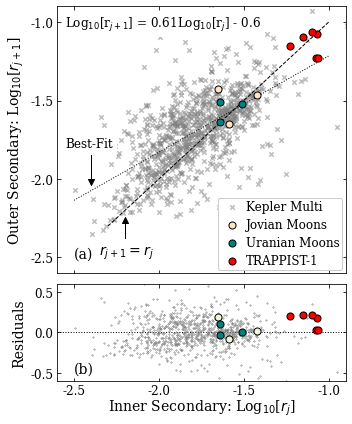

In [30]:
# plot the figure of sequential pea radius ratios

fig, ((ax, ax1)) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5.5, 2]})

fig.set_figwidth(5)
fig.set_figheight(6)

# plot the Kepler multiplanet systems
ax.scatter(loginner, logouter,\
    c = "grey", s = 20, label = "Kepler Multi", alpha = 0.5, marker = "x")

# plot the low mass systems of interest
ax.scatter(np.log10(inner_jupiter), np.log10(outer_jupiter),\
    color = "bisque", ec = "black", s = 50, label = "Jovian Moons", marker = "o", zorder = 100)
ax.scatter(np.log10(inner_uranus), np.log10(outer_uranus),\
    color = "teal", ec = "black", s = 50, label = "Uranian Moons", marker = "o", zorder = 100)
ax.scatter(np.log10(inner_trappist), np.log10(outer_trappist),\
    color = "red", edgecolor = "black", s = 50, label = "TRAPPIST-1", marker = "o", zorder = 100)

# generate a legend
ax.legend(loc = "lower right", fontsize = 12, framealpha = 1.0,\
    handletextpad=0.1, borderpad = 0.22, borderaxespad = 0.3, labelspacing = 0.4, columnspacing = 0.3)

# set the limits on the x-axis for both panels
lowlim = -2.6
highlim = -0.9
ax.set_xlim((lowlim, highlim))
ax1.set_xlim((lowlim, highlim))
ax.set_ylim((lowlim, highlim))

# set the tick labels size for all of the axes
ax.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)

# set the labels for the axes
ax.set_ylabel("Outer Secondary: Log$_{10}$[$r_{j+1}$]", fontsize = 14)
ax1.set_xlabel("Inner Secondary: Log$_{10}$[$r_{j}$]", fontsize = 14, labelpad = 0)
ax1.set_ylabel("Residuals", fontsize = 14)

# set the axis ticks and markers
ax.set_xticks([-2.5, -2.0, -1.5, -1.0])
ax.set_xticklabels([])
ax1.set_yticks([-0.5, 0.0, 0.5])
ax1.set_yticklabels(["-0.5", "0.0", "0.5"])
ax1.set_ylim((-0.6, 0.6))
ax1.set_xticks([-2.5, -2.0, -1.5, -1.0])
ax1.set_xticklabels(["-2.5", "-2.0", "-1.5", "-1.0"])
ax.set_yticks([-2.5, -2.0, -1.5, -1.0])
ax.set_yticklabels(["-2.5", "-2.0", "-1.5", "-1.0"])

# prepare the line of best-fit from linear regression
if lr.intercept > 0:
    sign = "+"
else:
    sign = "-"

# add the text for the line of best-fit
equation = "Log$_{10}$[r$_{j+1}$] = " + str(round(lr.slope, 2)) +\
    "Log$_{10}$[r$_{j}$] " + sign + " " + str(round(np.abs(lr.intercept), 2))
ta = ax.text(-2.55, -1.03, equation, fontsize = 12)
ta.set_bbox(dict(facecolor='white', alpha=1, edgecolor='none'))
#tb = ax.text(-2.55, -1.18, "Pearson R: " + str(round(lr.rvalue, 2)), fontsize = 12)
#tb.set_bbox(dict(facecolor='white', alpha=1, edgecolor='none'))

# plot the best-fit line
best_fit_x = np.linspace(-2.5, -1, 100)
best_fit_y = best_fit_x * lr.slope + lr.intercept
ax.plot(best_fit_x, best_fit_y, c = "black", ls = ":", lw = 1)

# plot y = x
ax.plot(np.linspace(-2.3, -1.0, 2), np.linspace(-2.3, -1.0, 2), c = "black", ls = "--", lw = 1)

# add labels for each of the lines (best-fit, y = x)
# and the corresponding arrow
tc = ax.text(-2.55, -1.8, "Best-Fit", fontsize = 12)
tc.set_bbox(dict(facecolor='white', alpha=1, edgecolor='none'))
ax.plot((-2.4, -2.4), (-1.85, -2.00), c = "black", lw = 1)
ax.scatter(-2.4, -2.02, c = "black", marker = "v")

td = ax.text(-2.35, -2.48, "$r_{j+1} = r_{j}$", fontsize = 14)
td.set_bbox(dict(facecolor='white', alpha=1, edgecolor='none'))
ax.plot((-2.2, -2.2), (-2.5, -2.27), c = "black", lw = 1)
ax.scatter(-2.2, -2.26, c = "black", marker = "^")

# generate the residual plot
# draw a line at zero
ax1.axhline(0, c = "black", lw = 1, zorder = 0, ls = "dotted")
# plot the exoplanets
ax1.scatter(loginner, resids, s = 2, c = "grey", zorder = 1, marker = "x", alpha = 0.5)
# plot the candidate pods
ax1.scatter(np.log10(inner_jupiter), resids_jupiter,\
    color = "beige", ec = "black", s = 50, label = "Jovian Moons", marker = "o", zorder = 2)
ax1.scatter(np.log10(inner_uranus), resids_uranus,\
    color = "teal", ec = "black", s = 50, label = "Uranian Moons", marker = "o", zorder = 3)
ax1.scatter(np.log10(inner_trappist), resids_trappist,\
    color = "red", ec = "black", s = 50, label = "TRAPPIST-1", marker = "o", zorder = 4)

# add the panel labels
ax.text(-2.5, -2.5, "(a)", fontsize = 14)
ax1.text(-2.5, -0.5, "(b)", fontsize = 14)

ax.tick_params(axis="y",direction="in", which="both")
ax.tick_params(axis="x",direction="in", which="both")
ax1.tick_params(axis="y",direction="in", which="both")
ax1.tick_params(axis="x",direction="in", which="both")

ax.tick_params(bottom=True, top = True, left = True, right = True, which = "both")
ax1.tick_params(bottom=True, top = True, left = True, right = True, which = "both")

fig.tight_layout()

savefigure = False
if savefigure: plt.savefig("radiiratios.png", dpi = 800)

In [31]:
print(pearsonr(loginner, logouter))

(0.6111844361570773, 7.664947092799711e-91)


In [32]:
# next, get the sequential period ratios
# for the exoplanets
inner_period_ratio = []
outer_period_ratio = []

# loop through the hosts
for h in hosts:
    host_df = df2[df2["KIC"] == h]
    # sort the planets by period
    host_df = host_df.sort_values(by = "koi_period")
    multiplicity = len(host_df)
    # make sure that we have at least triads of planets
    if multiplicity >= 3:
        for i in range(len(host_df) - 2):
            inner = host_df.iloc[i]
            middle = host_df.iloc[i+1]
            outer = host_df.iloc[i+2]

            # require that period ratios be smaller than 4
            # (same as Weiss et al. 2018)
            if middle["koi_period"] / inner["koi_period"] < 4:
                if outer["koi_period"] / middle["koi_period"] < 4:
                    inner_period_ratio.append(middle["koi_period"] / inner["koi_period"])
                    outer_period_ratio.append(outer["koi_period"] / middle["koi_period"])

# create the numpy arrays for plotting
inner_period_ratio = np.array(inner_period_ratio)
outer_period_ratio = np.array(outer_period_ratio)

loginnerperiod = np.log10(inner_period_ratio)
logouterperiod = np.log10(outer_period_ratio)

In [33]:
print(len(inner_period_ratio))

232


In [34]:
# do this same computation for the low mass systems of interest

inner_period_jupiter = []
outer_period_jupiter = []
inner_period_trappist = []
outer_period_trappist = []
inner_period_uranus = []
outer_period_uranus = []

for i in range(len(jupiter) - 2):
    inner = jupiter.iloc[i]
    middle = jupiter.iloc[i+1]
    outer = jupiter.iloc[i+2]
    inner_period_jupiter.append(middle["Period"] / inner["Period"])
    outer_period_jupiter.append(outer["Period"] / middle["Period"])
    
for i in range(len(trappist) - 2):
    inner = trappist.iloc[i]
    middle = trappist.iloc[i+1]
    outer = trappist.iloc[i+2]
    inner_period_trappist.append(middle["Period"] / inner["Period"])
    outer_period_trappist.append(outer["Period"] / middle["Period"])
    
for i in range(len(uranus) - 2):
    inner = uranus.iloc[i]
    middle = uranus.iloc[i+1]
    outer = uranus.iloc[i+2]
    inner_period_uranus.append(middle["Period"] / inner["Period"])
    outer_period_uranus.append(outer["Period"] / middle["Period"])

In [35]:
# do the linear regression on this data
lr_period = linregress(loginnerperiod, logouterperiod)
print(lr_period)

LinregressResult(slope=0.31461992379502074, intercept=0.18391237853062714, rvalue=0.30761655462384585, pvalue=1.783771939079534e-06, stderr=0.0641691287458807, intercept_stderr=0.01895169340660919)


In [36]:
# get the residuals for the exoplanets
resids_period = logouterperiod\
    - lr_period.slope * loginnerperiod - lr_period.intercept

# get the residuals for the other candidate pods
resids_period_jupiter = np.log10(outer_period_jupiter) - \
    lr_period.slope * np.log10(inner_period_jupiter) - lr_period.intercept

resids_period_uranus = np.log10(outer_period_uranus) - \
    lr_period.slope * np.log10(inner_period_uranus) - lr_period.intercept

resids_period_trappist = np.log10(outer_period_trappist) - \
    lr_period.slope * np.log10(inner_period_trappist) - lr_period.intercept

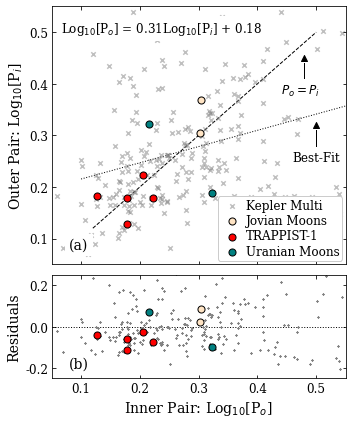

In [37]:
# generate the figure of period ratios

fig, ((ax, ax1)) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 2]})
fig.set_figwidth(5)
fig.set_figheight(6)

# plot the data from the peas-in-a-pod exoplanets
ax.scatter(loginnerperiod, logouterperiod,\
    c = "grey", s = 20, label = "Kepler Multi", alpha = 0.5, marker = "x")

# plot the low mass systems-of-interest
ax.scatter(np.log10(inner_period_jupiter), np.log10(outer_period_jupiter),\
    color = "bisque", ec = "black", s = 50, label = "Jovian Moons", marker = "o")
ax.scatter(np.log10(inner_period_trappist), np.log10(outer_period_trappist),\
    color = "red", ec = "black", s = 50, label = "TRAPPIST-1", marker = "o")
ax.scatter(np.log10(inner_period_uranus), np.log10(outer_period_uranus),\
    color = "teal", ec = "black", s = 50, label = "Uranian Moons", marker = "o")

"""
# add the lines for resonance in the outer period ratios
textxposition = 0.62
# 3:2
ax.axhline(np.log10(1.5), c = "black", ls = "-", lw = 1, zorder = 0)
t1 = ax.text(textxposition, np.log10(1.58), "3:2", fontsize = 14, ha = "left")
t1.set_bbox(dict(facecolor='white', alpha=1, edgecolor='none'))

# 2:1
ax.axhline(np.log10(2), c = "black", ls = "-", lw = 1, zorder = 0)
t2 = ax.text(textxposition, np.log10(2.11), "2:1", fontsize = 14, ha = "left")
t2.set_bbox(dict(facecolor='white', alpha=1, edgecolor='none'))

# 3:1
ax.axhline(np.log10(3), c = "black", ls = "-", lw = 1, zorder = 0)
t3 = ax.text(textxposition, np.log10(3.14), "3:1", fontsize = 14, ha = "left")
t3.set_bbox(dict(facecolor='white', alpha=1, edgecolor='none'))
"""

ax.set_xlim((0.05, 0.55))
ax1.set_xlim((0.05, 0.55))
ax.set_ylim((0.05, 0.55))

# set the tick label fontsize
ax.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)

# generate a legend
ax.legend(loc = "lower right", fontsize = 12, ncol = 1, framealpha = 1.0,\
    handletextpad=0.1, borderpad = 0.22, borderaxespad = 0.3, labelspacing = 0.2, columnspacing = 0.3)

### PLOT THE BEST-FIT LINE ###
best_fit_x = np.linspace(0.1, 0.6, 100)
best_fit_y = best_fit_x * lr_period.slope + lr_period.intercept
ax.plot(best_fit_x, best_fit_y, c = "black", ls = ":", lw = 1, zorder = 0)

### DISPLAY THE BEST-FIT LINE ###
if lr_period.intercept > 0:
    sign = "+"
else:
    sign = "-"
equation = "Log$_{10}$[P$_{o}$] = " + str(round(lr_period.slope, 2)) +\
    "Log$_{10}$[P$_{i}$] " + sign + " " + str(round(np.abs(lr_period.intercept), 2))
t4 = ax.text(0.065, 0.50, equation, fontsize = 12)
t4.set_bbox(dict(facecolor='white', alpha=1, edgecolor='none'))
#t5 = ax.text(0.065, 0.505, "Pearson R: " + str(round(lr_period.rvalue, 2)), fontsize = 12)
#t5.set_bbox(dict(facecolor='white', alpha=1, edgecolor='none'))


# add the axis text labels
ax1.set_xlabel("Inner Pair: Log$_{10}$[P$_{o}$]", fontsize = 14)
ax1.set_ylabel("Residuals", fontsize = 14)
ax.set_ylabel("Outer Pair: Log$_{10}$[P$_{i}$]", fontsize = 14)

# plot the residuals for the exoplanets
ax1.scatter(loginnerperiod, resids_period, s = 2, c = "grey", marker = "x")
# draw a line at zero residual
ax1.axhline(0, c = "black", lw = 1, zorder = 0, ls = "dotted")
# add the residuals for the other candidate pods
ax1.scatter(np.log10(inner_period_jupiter), resids_period_jupiter,\
    color = "bisque", ec = "black", s = 50, label = "Jovian Moons", marker = "o", zorder = 2)
ax1.scatter(np.log10(inner_period_uranus), resids_period_uranus,\
    color = "teal", ec = "black", s = 50, label = "Uranian Moons", marker = "o", zorder = 3)
ax1.scatter(np.log10(inner_period_trappist), resids_period_trappist,\
    color = "red", ec = "black", s = 50, label = "TRAPPIST-1", marker = "o", zorder = 4)

# set more axis labels
ax1.set_ylim(-0.25, 0.25)
ax1.set_yticks([-0.2, 0.0, 0.2])
ax1.set_yticklabels(["-0.2", "0.0", "0.2"])

# plot the equal period ratio line y = x
ax.plot(np.linspace(0.12, 0.5, 2), np.linspace(0.12, 0.5, 2), c = "black", ls = "--", zorder = 0, lw = 1)

# add the markings for panel (a) and (b)
t10 = ax.text(0.08, 0.08, "(a)", fontsize = 14)
t10.set_bbox(dict(facecolor='white', alpha=1, edgecolor='none'))
t11 = ax1.text(0.08, -0.2, "(b)", fontsize = 14)
t11.set_bbox(dict(facecolor='white', alpha=1, edgecolor='none'))

# add the labels for best fit line
ta = ax.text(0.46, 0.25, "Best-Fit", fontsize = 12)
ta.set_bbox(dict(facecolor='white', alpha=1, edgecolor='none'))
ax.plot((0.5, 0.5), (0.27, 0.31), c = "black", lw = 1)
ax.scatter(0.5, 0.32, c = "black", marker = "^")

# add the labels for equal period ratios
tb = ax.text(0.44, 0.38, "$P_{o} = P_{i}$", fontsize = 12)
tb.set_bbox(dict(facecolor='white', alpha=1, edgecolor='none'))
ax.plot((0.48, 0.48), (0.37, 0.44), c = "black", lw = 1)
ax.scatter(0.48, 0.45, c = "black", marker = "^")


# set the tick marks/labels and limits for both axes
ax1.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5])
ax1.set_xticklabels(["0.1", "0.2", "0.3", "0.4", "0.5"])
ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_yticklabels(["0.1", "0.2", "0.3", "0.4", "0.5"])
ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_xticklabels([])

ax.tick_params(axis="y",direction="in", which="both")
ax.tick_params(axis="x",direction="in", which="both")
ax1.tick_params(axis="y",direction="in", which="both")
ax1.tick_params(axis="x",direction="in", which="both")

ax.tick_params(bottom=True, top = True, left = True, right = True, which = "both")
ax1.tick_params(bottom=True, top = True, left = True, right = True, which = "both")

fig.tight_layout()

savefigure = False
if savefigure: plt.savefig("periodratios.png", dpi = 800)


In [38]:
lr_period

LinregressResult(slope=0.31461992379502074, intercept=0.18391237853062714, rvalue=0.30761655462384585, pvalue=1.783771939079534e-06, stderr=0.0641691287458807, intercept_stderr=0.01895169340660919)

In [39]:
host_multiplicities = []
host_inner_periods = []
host_masses = []

for h in hosts:
    host_df = df2[df2["KIC"] == h]
    # sort the planets by period
    host_df = host_df.sort_values(by = "koi_period")
    host_df.reset_index(drop = True)
    multiplicity = len(host_df)
    first = host_df.iloc[0]
    host_multiplicities.append(multiplicity)
    host_inner_periods.append(first["koi_period"])
    host_masses.append(first["bergerstarmass"])

host_multiplicities = np.array(host_multiplicities)
host_inner_periods = np.array(host_inner_periods)

inner_period_df = pd.DataFrame([host_multiplicities, host_inner_periods, host_masses]).T
inner_period_df.columns = ["Multiplicity", "InnerP", "Mass_st"]

In [40]:
inner_period_df

,Multiplicity,InnerP,Mass_st
0,3.0,6.887071,1.140
1,2.0,3.487689,1.122
2,5.0,3.696121,0.922
3,2.0,0.837491,0.930
4,5.0,5.286920,0.766
...,...,...,...
590,2.0,4.781139,0.943
591,2.0,4.371989,0.857
592,2.0,8.292756,1.031
593,2.0,8.739676,0.659


In [41]:
IO_PERIOD = 1.77 # days
ARIEL_PERIOD = 2.52 # days
TRAPPIST1b_PERIOD = 1.51 # days

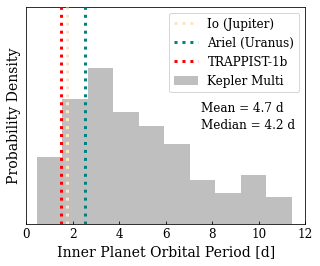

In [42]:
fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(5)

inner_period_df = inner_period_df[inner_period_df["InnerP"] < 12]
to_plot = inner_period_df[inner_period_df["Multiplicity"] > 2]["InnerP"]

bins = ax.hist(to_plot, bins = 10,\
    density = True, alpha = 0.5, color = "grey", label = "Kepler Multi")
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlim(0, 12)
ax.set_ylim(0, 0.25)

ax.set_xlabel("Inner Planet Orbital Period [d]", fontsize = 14)
ax.set_ylabel("Probability Density", fontsize = 14, labelpad = 5)
ax.set_yticks([])
ax.set_yticklabels([])

avg = np.average(to_plot)
med = np.median(to_plot)

# plot the low mass candidate pods
#ax.scatter(IO_PERIOD, 0.1441, color = "bisque", ec = "black", s = 70, zorder = 10, marker = "o", label = "Io (Jupiter)")
ax.axvline(IO_PERIOD, color = "bisque", ls = ":", lw=3, zorder = 10, label = "Io (Jupiter)")
#ax.scatter(ARIEL_PERIOD, 0.1441, color = "teal", ec = "black", s = 70, zorder = 10, marker = "o", label = "Ariel (Uranus)")
ax.axvline(ARIEL_PERIOD, color = "teal", ls = ":", lw=3, zorder = 10, label = "Ariel (Uranus)")
#ax.scatter(TRAPPIST1b_PERIOD, 0.077, color = "red", ec = "black", s = 70, zorder = 10, marker = "o", label = "TRAPPIST-1b")
ax.axvline(TRAPPIST1b_PERIOD,color = "red", ls = ":", lw=3, zorder = 10, label = "TRAPPIST-1b")

ax.legend(loc = "upper right", fontsize = 12)

ax.tick_params(axis="y",direction="in", which="both")
ax.tick_params(axis="x",direction="in", which="both")

ax.text(7.5, 0.13, f"Mean = {np.round(avg, 1)} d", fontsize = 12)
ax.text(7.5, 0.11, f"Median = {np.round(med, 1)} d", fontsize = 12)

saveFigure = False
if saveFigure: plt.savefig("orbitalperiods.png", dpi = 800)


In [43]:
len(to_plot)

177

In [44]:
bins

(array([0.07722228, 0.14414825, 0.18018531, 0.1287038 , 0.11325934,
        0.09266673, 0.05148152, 0.03603706, 0.05662967, 0.03088891]),
 array([ 0.45328742,  1.55071377,  2.64814013,  3.74556649,  4.84299284,
         5.9404192 ,  7.03784556,  8.13527191,  9.23269827, 10.33012463,
        11.42755098]),
 <BarContainer object of 10 artists>)

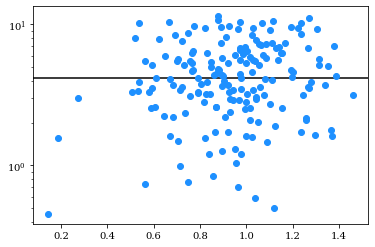

In [45]:
fig, ax = plt.subplots()

plot_df = inner_period_df[inner_period_df["Multiplicity"] > 2]


ax.scatter(plot_df["Mass_st"], plot_df["InnerP"], c = "dodgerblue")
ax.axhline(med, c = "black", zorder = 0)
ax.set_yscale("log")